In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings('ignore')
import datetime
import gc
gc.collect()
import lightgbm
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from tqdm import tqdm

In [17]:
main_dir='/kaggle/input/m5-forecasting-accuracy/'

sales=pd.read_csv(main_dir+'sales_train_evaluation.csv')
print('Sales Loaded')

calendar=pd.read_csv(main_dir+'calendar.csv',dayfirst=True,keep_date_col=True)
print('Calendar Loaded')

sales_price=pd.read_csv(main_dir+'sell_prices.csv')
print('Sell Price Loaded')


Sales Loaded
Calendar Loaded
Sell Price Loaded


In [18]:
#The list of main columns
id_cols=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [19]:
#Checking what is the last date which is present, so that we can add the next 28 days using which we will do the forecasting
print('We have data available till ',sales.columns[-1])

We have data available till  d_1941


In [20]:
#We are now first reducing the size of our df, by changing the datatype from object.
#Reference: https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling/notebook
#Downcast in order to save memory

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in (enumerate(types)):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales=downcast(sales)
print('sales Completed...')

calendar=downcast(calendar)
print('calendar Completed...')

sales_price=downcast(sales_price)
print('sales_price Completed...')

sales Completed...
calendar Completed...
sales_price Completed...


In [21]:
#adding the dates of evaluation data
for d in range(1942,1942+28):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

### 1. Time based features
- A trend was visible on the week ends, so also capturing that as "is_week_off".

- Also, sales of products depend on certain events,so I have added a feature called Days to next event.

- Then Christmas has a sales of 0, so have added is_christmas as a feature.

- Also added, some basic features like dates, months etc, because in EDA, on a high level we could see that the sales were high on the first 15 days, so this data would capture that detail.

- I had added more features like release_date,day_to_sunday, but that had made my model overfit and worked more as noise.

In [22]:
calendar['date']=pd.to_datetime(calendar['date'], dayfirst=True)
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [23]:
event_dates=pd.to_datetime(calendar[(calendar['event_name_1']!='no_event') | (calendar['event_name_2']!='no_event')]['date'])


def days_to_event(i):
    j=(event_dates.values[np.absolute(event_dates-i).argmin()]-i).astype('timedelta64[D]')
    #print(j)
    return j

calendar['days_to_next_event']=np.array(list(days_to_event(a) for a in tqdm(calendar['date'].values)))

calendar['days_to_next_event']=calendar['days_to_next_event'].dt.days

calendar.head()

100%|██████████| 1969/1969 [00:00<00:00, 2750.83it/s]


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days_to_next_event
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0


In [24]:
f=lambda x: 1 if x==7 or x==1 or x==2 else 0
calendar['is_weekoff']=calendar['wday'].map(f) 
calendar['is_weekoff']=calendar['is_weekoff']
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,days_to_next_event,is_weekoff
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0


In [25]:
calendar['day_of_month']=calendar['date'].dt.day.astype(np.int16)

calendar['week']=calendar['date'].dt.isocalendar().week
calendar['week']=pd.Categorical(calendar['week'])

#calendar['day_to_sun']=7-calendar['wday']

calendar['day_of_month']=calendar['day_of_month'].astype('category')

### Sales Price:
- Sales Price based features have proven to provide good results rather than the sold data.

In [26]:
#Melting the data, so that processing can be done
melted_data = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [27]:
#Merging other columns with the data
processed_data = pd.merge(melted_data, calendar, on='d', how='left')
processed_data = pd.merge(processed_data, sales_price, on=['store_id','item_id','wm_yr_wk'], how='left')

del melted_data
gc.collect()

23

In [28]:
#Creating a dictionary of category and their codes, and further converting the categories
#column to codes, which would be the label encoded data for these attributes
d_id = dict(zip(processed_data.id.cat.codes, processed_data.id))
d_item_id = dict(zip(processed_data.item_id.cat.codes, processed_data.item_id))
d_dept_id = dict(zip(processed_data.dept_id.cat.codes, processed_data.dept_id))
d_cat_id = dict(zip(processed_data.cat_id.cat.codes, processed_data.cat_id))
d_store_id = dict(zip(processed_data.store_id.cat.codes, processed_data.store_id))
d_state_id = dict(zip(processed_data.state_id.cat.codes, processed_data.state_id))

pickle.dump([d_id,d_item_id,d_dept_id,d_cat_id,d_store_id,d_state_id], open('dict.pkl','wb'))

**I had choosed label encoding over mean encoding because the results were very poor using mean encoding, but label encoding provided a good result**

In [29]:
events=['event_name_1','event_type_1','event_name_2','event_type_2']
from sklearn.preprocessing import LabelEncoder
for i in events:
    processed_data[i] = processed_data[i].cat.add_categories("nan").fillna("nan")
    processed_data[i]=LabelEncoder().fit_transform(processed_data[i]).astype(np.int8)
#Label encoding the categories events

In [30]:
#converting the day column to integers for easy acess and processing.
def day(a):
    n=a.split('_')[1]
    return n

processed_data['d']=processed_data['d'].apply(day)
processed_data['d']=processed_data['d'].astype(int)

In [31]:
#converting the categorical columns to their codes= Label Encoding
cols = processed_data.dtypes.index.tolist()
types = processed_data.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        processed_data[cols[i]] = processed_data[cols[i]].cat.codes

In [32]:
events=['event_name_1','event_type_1','event_name_2','event_type_2']

for i in events:
    processed_data[i]=processed_data[i].astype('category')
#Assigning the type of these columns as Categorical.

### Features based on Lag:
- Here I choose the lags after 28, because lags before 28, were overfitting my data and because of which my private score was less, but public score was extremely high in the range of 5.XX.
- Also the moving average data made my model overfit, and hence I choose to remove it, and instead use derived features using them.
- Lagged events were added based on the logic that sales related to events happen either 2 days before or 2 days after and not mostly on the day of event, hence adding those also as events, to capture the events effect.

In [33]:
lags = [28,35,42,49]

from tqdm import tqdm

for lag in tqdm(lags):
    processed_data['sold_lag_'+str(lag)] = processed_data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

100%|██████████| 4/4 [00:36<00:00,  9.08s/it]


In [34]:
lags2 = [-2,-1,1,2]
for lag in lags2:
    processed_data['event1_lag_'+str(lag)] = processed_data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['event_name_1'].shift(lag).astype(np.float16)
    processed_data['event1_lag_'+str(lag)].fillna(100, inplace=True)
    processed_data['event1_lag_'+str(lag)]=processed_data['event1_lag_'+str(lag)].astype(np.int8)
    processed_data['event1_lag_'+str(lag)]=processed_data['event1_lag_'+str(lag)].astype('category')

In [35]:
#Giving a separate categorical feature whether a day is christmas, so that the zero sales on that day can be captures
from tqdm import tqdm

years=processed_data['date'].dt.year.unique()

processed_data['is_christmas']=0

for y in tqdm(years):
    christmas=pd.to_datetime('25-12-'+str(y),dayfirst=True)
    processed_data['is_christmas'].loc[processed_data['date'][processed_data['date']==christmas].index]=1

100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


### High Level means:
- The research paper released by the organizers, had mentioned that at a low level of item sales there was high level of noise involved hence, the predictions were poor.
- But at a high level of state, department etc, the seasonality was captured better.
- Also there are chances that the columns are correlated and hence we selected these features, which really helped in improving the performance of the model.
- We have taken average at all levels and correlated levels as well, so that the seasonality and trend is captured better.

In [36]:
#capturing mean data at all levels, as chances are that they are related
processed_data['item_sold_avg'] = processed_data.groupby('item_id')['sold'].transform('mean').astype(np.float16)    
processed_data['state_sold_avg'] = processed_data.groupby('state_id')['sold'].transform('mean').astype(np.float16)    #total 3 unique values, 1 for each state
processed_data['store_sold_avg'] = processed_data.groupby('store_id')['sold'].transform('mean').astype(np.float16)  #10 unique values
processed_data['cat_sold_avg'] = processed_data.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
processed_data['dept_sold_avg'] = processed_data.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
processed_data['cat_dept_sold_avg'] = processed_data.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
processed_data['store_item_sold_avg'] = processed_data.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
processed_data['cat_item_sold_avg'] = processed_data.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
processed_data['dept_item_sold_avg'] = processed_data.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
processed_data['state_store_sold_avg'] = processed_data.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
processed_data['state_store_cat_sold_avg'] = processed_data.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
processed_data['store_cat_dept_sold_avg'] = processed_data.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

**Linear Week:** This feature captures the sales happening on a seasonal basis and is one of the important features in the final model.

The wm_yr_wk, have different numbers for each week but have different numbers every year, hence linear week was used.

In [37]:
from sklearn.preprocessing import LabelEncoder

processed_data['wm_yr_wk_linear']=LabelEncoder().fit_transform(processed_data['wm_yr_wk'].values).astype(np.int16)

### Price difference:
- We tried with difference of price at different intervals 7, 14, 28. But only adding a 7 day difference improved the model performance.
- Adding more features worked as noise, rather than improving the models performance.

In [38]:
processed_data['price_lag'] = processed_data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sell_price'].shift(7).astype(np.float16)
processed_data['price-diff']=processed_data['price_lag']-processed_data['sell_price']
processed_data.drop(['price_lag'], axis=1, inplace=True)

In [39]:
#Dropping the columns which have NA sell_price because they will bring unwanted bias 
#to the model

processed_data=downcast(processed_data)
processed_data=processed_data.loc[processed_data['sell_price'].dropna().index]

In [40]:
'''pickle.dump(processed_data,open('stage_2.pkl','wb'))'''

"pickle.dump(processed_data,open('stage_2.pkl','wb'))"

**It was written in a discussion that adding the last 2 digits of the price multiplied by 100 as a feature improved the performance, and hence tried adding them**

In [41]:
#processed_data=pickle.load(open('stage_2.pkl','rb'))
[d_id,d_item_id,d_dept_id,d_cat_id,d_store_id,d_state_id]=pickle.load(open('dict.pkl','rb'))
processed_data['decimal']=processed_data['sell_price'].apply(lambda x: 100*(x-int(x))).astype(np.int16)

**Comparing the price difference over expanding mean**

In [42]:
#Checking the diff of moving average with respect to curent price
processed_data['expanding_price_mean'] = processed_data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sell_price'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)
processed_data['diff_moving_mean']=processed_data['expanding_price_mean']-processed_data['sell_price']
processed_data.drop(['expanding_price_mean'], axis=1, inplace=True)

In [43]:
processed_data['price-diff']=processed_data['price-diff'].astype(np.float16)
processed_data.drop(['wday'], axis=1, inplace=True)
processed_data['decimal']=processed_data['decimal'].astype(np.int8)
from sklearn.preprocessing import LabelEncoder

processed_data['year']=LabelEncoder().fit_transform(processed_data['year']).astype(np.int8)

- Comparing daily sales price with overall average sales price and giving the difference, and there are instances when a high demand product price increases and low demand products price remains stagnant. So this data point captures that detail.
- This was taken from a discussion in Kaggle

In [44]:
processed_data['daily_avg_price'] = processed_data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sell_price'].transform('mean').astype(np.float16)
processed_data['avg_price'] = processed_data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sell_price'].transform('mean').astype(np.float16)
processed_data['selling_trend'] = (processed_data['daily_avg_price'] - processed_data['avg_price']).astype(np.float16)
processed_data.drop(['daily_avg_price','avg_price'],axis=1,inplace=True)

**Dropping these 2 columns as they are already been captured by the ID.**

In [45]:
list3=['cat_id','state_id']
for i in list3:
    processed_data.drop([i], axis=1, inplace=True)
    
processed_data.drop(['date'],axis=1, inplace=True)

In [46]:
# removing the top 100 which are only NAN
processed_data = processed_data[processed_data['d']>=100]

In [47]:
processed_data=downcast(processed_data)

In [48]:
pickle.dump(processed_data,open('processed_pickle.pkl','wb'))

In [49]:
'''processed_data=pickle.load(open('/kaggle/input/m5-model-features/processed_pickle.pkl','rb'))'''

"processed_data=pickle.load(open('/kaggle/input/m5-model-features/processed_pickle.pkl','rb'))"

In [50]:
processed_data.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'd', 'sold', 'wm_yr_wk',
       'weekday', 'month', 'year', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'days_to_next_event', 'is_weekoff', 'day_of_month', 'week',
       'sell_price', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42',
       'sold_lag_49', 'event1_lag_-2', 'event1_lag_-1', 'event1_lag_1',
       'event1_lag_2', 'is_christmas', 'item_sold_avg', 'state_sold_avg',
       'store_sold_avg', 'cat_sold_avg', 'dept_sold_avg', 'cat_dept_sold_avg',
       'store_item_sold_avg', 'cat_item_sold_avg', 'dept_item_sold_avg',
       'state_store_sold_avg', 'state_store_cat_sold_avg',
       'store_cat_dept_sold_avg', 'wm_yr_wk_linear', 'price-diff', 'decimal',
       'diff_moving_mean', 'selling_trend'],
      dtype='object')

In [51]:
valid_data=processed_data[(processed_data['d']>=1914) & (processed_data['d']<1942)][['id','d','sold']]
test_data = processed_data[processed_data['d']>=1942][['id','d','sold']]
eval_preds = test_data['sold']
valid_preds=valid_data['sold']

In [52]:
cat_column=[]
for i in processed_data.columns:
    if(str(processed_data.dtypes[i])=='category'):
        cat_column.append(i)

In [53]:
cat_column

['event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'event1_lag_-2',
 'event1_lag_-1',
 'event1_lag_1',
 'event1_lag_2']

### Initially, I had used the following hyperparameters which were mentioned in a discussion:

learning_rate= 0.05,
        subsample=0.6,
        feature_fraction=0.6,
        num_iterations = 1200,
        max_bin=350,
        num_leaves= 100,
        lambda_l2=0.003,
        max_depth=200,
        min_data_in_leaf= 80,
        force_row_wise= True,

**And following was my WRMSSE**


![Result](https://i.imgur.com/L9N3FYw.png)

#### After Hyperparameter Tuning these are the best parameters:

'''Best params:

		n_estimators: 567
        
		subsample: 0.24877363747333814
        
		feature_fraction: 0.9496060936873285
        
		num_iterations: 600
        
		max_bin: 480
        
		learning_rate: 0.4541157216562791
        
		lambda_l2: 0.24775163612644088
        
		num_leaves: 100
        
		max_depth: 340
        
		min_data_in_leaf: 130'''

In [55]:
#Reference: https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling
for store in d_store_id:
    df = processed_data[processed_data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid_csv, y_valid_csv = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        learning_rate= 0.4,
        subsample=0.3,
        feature_fraction=0.9,
        num_iterations = 600,
        max_bin=480,
        num_leaves= 100,
        lambda_l2=0.2,
        max_depth=200,
        min_data_in_leaf= 130,
        force_row_wise= True,
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid_csv,y_valid_csv)],
             eval_metric='rmse',  verbose=100, early_stopping_rounds=20,categorical_feature=cat_column)
    valid_preds[X_valid_csv.index] = model.predict(X_valid_csv)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    pickle.dump(model, open(filename,'wb'))
    del model, X_train, y_train, X_valid_csv, y_valid_csv
    gc.collect()

*****Prediction for Store: CA_1*****
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
*****Prediction for Store: CA_2*****
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
*****Prediction for Store: CA_3*****
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 wil

In [56]:
#Get the actual validation results
#Ref: https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling

valid_data['sold'] = valid_preds
validation = valid_data[['id','d','sold']]
validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test_data['sold'] = eval_preds
evaluation = test_data[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
# submit.memory_usage().sum()
submit.to_csv('submission.csv',index=False)

In [57]:
model=pickle.load(open('/kaggle/working/modelTX_2.pkl','rb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

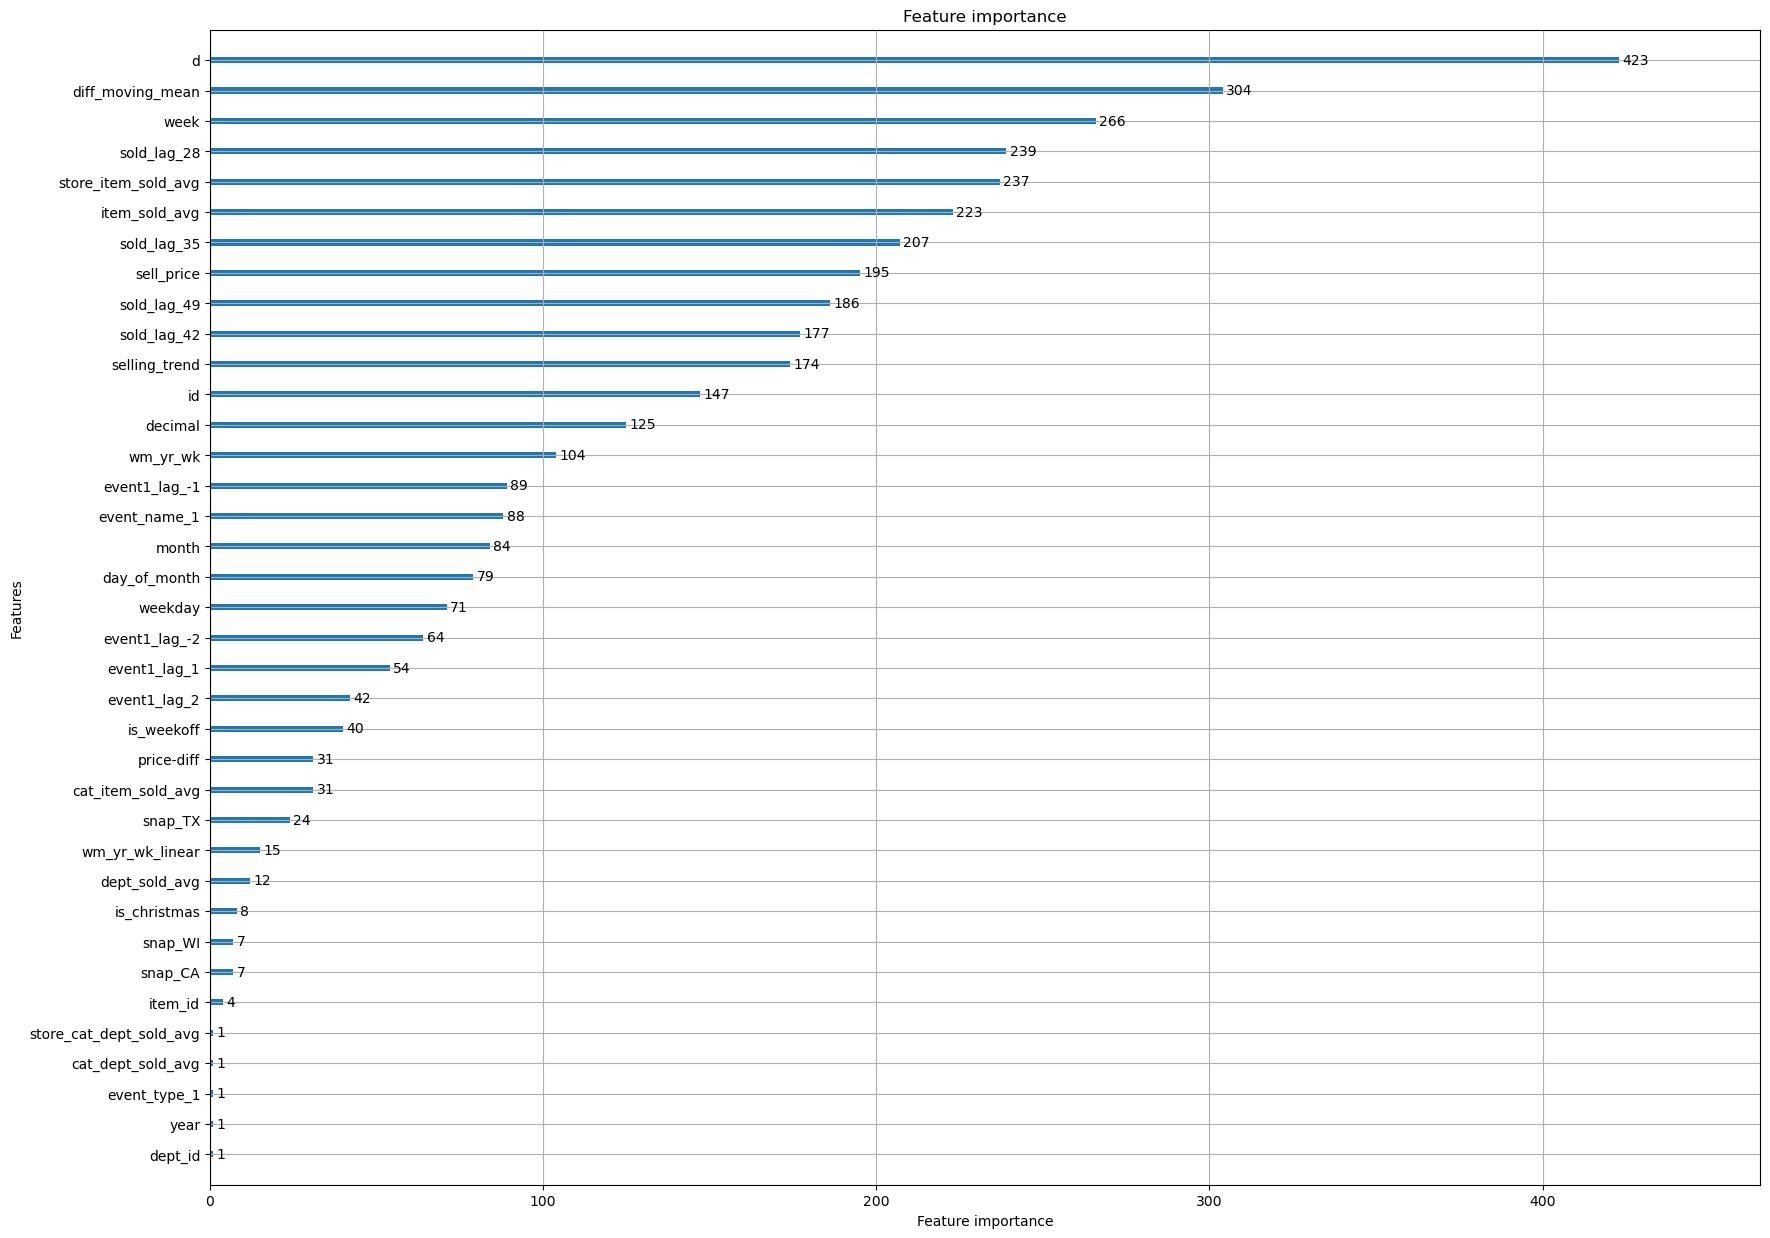

In [58]:
lightgbm.plot_importance(model, figsize=(20,15))

In [59]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

### After Tuning the parameters using Optuna Following is my Best Result which is among the top 100.

![After Tuning](https://i.imgur.com/TKe5myT.png)

![Relative Leaderboard](https://i.imgur.com/oeY6JyK.png)

#### More Insights:
- I had submitted multiple submissions with different features, where some features drastically increased the error on the evaluation data, because of overfitting.

![Failed Submissions](https://i.imgur.com/j5goWt5.png)